In [1]:
# general
import sys, os, path
import datetime

# nn related
import torch
import torch as th
import torch.nn as nn
import numpy as np
from numpy import linalg as la
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# postprocessing
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
import seaborn as sns

# own scrips
sys.path.insert(1, '/home/leonriccius/PycharmProjects/data_driven_rans')

from scripts import preProcess
from scripts import TensorBasedNN
from scripts.TensorBasedNN import TBNN_generic
from scripts.utilities import get_invariants, get_tensor_functions
from scripts.torchToFoam import writesymmtensor
from scripts.barymap import BarMap
# from utilities import mask_boundary_points
# from utilities import get_invariants
# from utilities import get_tensor_functions
# from torchToFoam import writesymmtensor

# standard datatype
dtype = torch.double

In [2]:
# set path to models and initialise arrays
model_path = '../storage/models/periodic_hills/no_t_norm/ling/model.pt'

model = th.load(model_path)
_ = model.eval()  # mandatory, see torch.load doc

In [3]:
# read in tensor data
pred_path = '/home/leonriccius/OpenFOAM/leonriccius-v2006/run/periodic_hills_RANS/2d-mesh/700_dd/'
time = '0'

s = th.load(os.sep.join([pred_path, time, 'S-torch.th']))
r = th.load(os.sep.join([pred_path, time, 'R-torch.th']))
epsilon0 = th.load(os.sep.join([pred_path, time, 'epsilon-torch.th']))
k0 = th.load(os.sep.join([pred_path, time, 'k-torch.th']))
cellCenters = th.load(os.sep.join([pred_path, time, 'cellCenters-torch.th']))

# expand k
k = k0.unsqueeze(0).unsqueeze(0).expand(3,3,k0.size()[0])
k = k.permute(2, 0, 1)

# expand epsilon
epsilon = epsilon0.unsqueeze(0).unsqueeze(0).expand(3,3,epsilon0.size()[0])
epsilon = epsilon.permute(2, 0, 1)

# normalize S and R
s_hat = k/epsilon*s
r_hat = k/epsilon*r

inv = get_invariants(s_hat, r_hat)
t = get_tensor_functions(s_hat, r_hat).reshape(-1,10,9)
index = th.isnan(t[:,4,0])
# t[index,4,:] = 0.0 #  = 0.0

In [4]:
th.max(th.isnan(t))

tensor(False)

In [8]:
b_pred,_ = model(inv,t)

In [9]:
b_pred = b_pred.reshape(-1,3,3)
b_pred.shape

torch.Size([6111, 3, 3])

In [10]:
b_list = [('Inlet', 'cyclic'),
          ('Outlet', 'cyclic'),
          ('TopWall', 'fixedValue'),
          ('BottomWall', 'fixedValue'),
          ('SideWall1', 'empty'),
          ('SideWall2', 'empty')]

In [11]:
# writesymmtensor(b_pred, os.sep.join([pred_path, time, 'b_dd']), b_list)

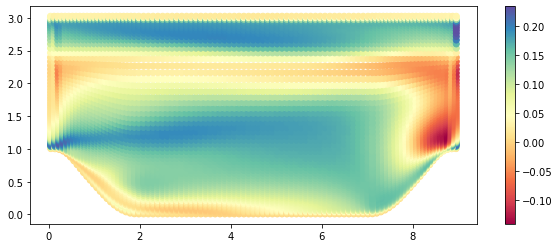

In [12]:
fig, ax = plt.subplots(figsize=(10,4))
b_dd = ax.scatter(cellCenters[:,0], cellCenters[:,1], c=b_pred[:,0,0].detach().numpy(), cmap="Spectral")
fig.colorbar(b_dd)
# ax.scatter(cellCenters[index,0], cellCenters[index,1])

In [13]:
[(th.max(t[:,i,0]), i) for i in range(9)]

[(tensor(2.3627, dtype=torch.float64), 0),
 (tensor(8.8460, dtype=torch.float64), 1),
 (tensor(2.9929, dtype=torch.float64), 2),
 (tensor(-2.5770e-09, dtype=torch.float64), 3),
 (tensor(2.9329, dtype=torch.float64), 4),
 (tensor(4.4464, dtype=torch.float64), 5),
 (tensor(39.8564, dtype=torch.float64), 6),
 (tensor(51.4162, dtype=torch.float64), 7),
 (tensor(0.1470, dtype=torch.float64), 8)]

In [14]:
index = th.isnan(b_pred[:,0,0])
print(index)

tensor([False, False, False,  ..., False, False, False])


In [15]:
b_pred_cut = b_pred[index==False,:,:]
b_pred_nan = b_pred[index==True,:,:]
cellCenters_cut = cellCenters[index==False,:]
cellCenters_nan = cellCenters[index==True,:]
b_pred_nan.shape

torch.Size([0, 3, 3])

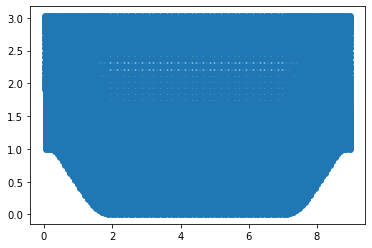

In [16]:
fig, ax = plt.subplots()
ax.scatter(cellCenters[:,0], cellCenters[:,1])

for i in range(3):
    for j in range(3):
        index = th.isnan(b_pred[:,i,j])
        ax.scatter(cellCenters[index,0], cellCenters[index,1])

In [17]:
from scipy.spatial.distance import cdist

def closest_node(node, nodes):
    index = cdist([node], nodes).argmin()
    return nodes[index], index

def sort_by_distance(node, nodes):
    return np.sort(cdist([node], nodes)), np.argsort(cdist([node], nodes)).flatten()

In [18]:
my_point = (2.,1.)

In [19]:
my_node, _ = closest_node(my_point, cellCenters[:,0:2])

In [20]:
node_dist, node_list = sort_by_distance(my_point, cellCenters[:,0:2])

In [21]:
cellCenters[node_list[0:4],0:2]

array([[1.98105 , 1.01584 ],
       [1.98105 , 0.960763],
       [1.98105 , 1.07313 ],
       [2.08601 , 1.01584 ]], dtype=float32)

In [22]:
import scipy.interpolate as spi
grid_x, grid_y = cellCenters[:,0], cellCenters[:,1]
b_interp = spi.griddata(cellCenters_cut[:,0:2],
                        b_pred_cut[:,0,0].detach().numpy(),
                        (cellCenters_nan[:,0], cellCenters_nan[:,1]))

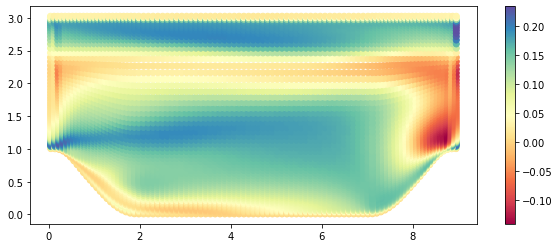

In [23]:
fig, ax = plt.subplots(figsize=(10,4))
b_dd = ax.scatter(cellCenters_cut[:,0], cellCenters_cut[:,1], c=b_pred_cut[:,0,0].detach().numpy(), cmap="Spectral")
fig.colorbar(b_dd)
# ax.scatter(cellCenters[index,0], cellCenters[index,1])
ax.scatter(cellCenters_nan[:,0], cellCenters_nan[:,1], c=b_interp)

In [24]:
bary = BarMap()

In [25]:
bary.load_from_variable(b_pred_cut.detach().numpy(), cellCenters_cut[:,0:2])
bary.calculate_barycentric_coordinates()

(0.0, 1.0)

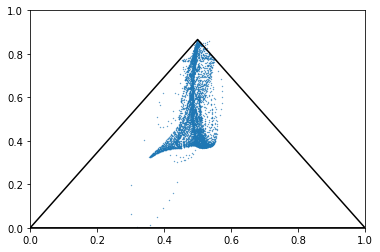

In [26]:
fig, ax = plt.subplots()
bary.plot_triangle(ax)
bary.plot_data_points(ax)
plt.xlim([0,1])
plt.ylim([0,1])